In [1]:
# import matplotlib.pyplot as plot
# import numpy as np
# import gudhi

# # rips_on_tore3D_1307.pers obtained from write_persistence_diagram method
# persistence_file='/home/bazyli/gitworkspace/gitBKrp/persistence/pcodebooks/rawdata/exp01_synthetic/pd_gauss_0_1/Circle/11.h5.pc.simba.1.00001_3.persistence'
# a=gudhi.plot_persistence_diagram(persistence_file=persistence_file,
#     legend=True)
    
# arr = gudhi.read_persistence_intervals_in_dimension(persistence_file, only_this_dim=1)
# plot.show()

# Matlab data loading and processing

In [155]:
import numpy as np
import scipy.io
from gudhi.representations.preprocessing import BirthPersistenceTransform, DiagramScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from preprocessing import *
from persistent_bow import *
from visualization import *

In [156]:
data_path = "./pd.mat"
data_mat = scipy.io.loadmat(data_path)
data = data_mat["pds"]

In [157]:
data.shape # Here are 50 diagrams (rows), 7 types(cols) = 350 diagrams

(50, 7)

In [158]:
data[0][1].shape # each diagram has n rows and 2 colums # here we get first diagram from type "1"

(23, 2)

In [159]:
# y - labels - type of diagram [0-7]
# We transpose to iterate over diagram list
y = []
for label, diagram_list in enumerate(data.T):
    y += len(diagram_list) * [label]
y = np.array(y)

# data.T = 2d array of diagrams as row, column as type
X = data.T.reshape(-1)

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [201]:
pipeline = Pipeline([
    ("name1", BirthPersistenceTransform()),
    ("name2", DiagramScaler(
        use=True,
        scalers=[
            ((0,), MaxAbsScaler(copy=False)),
            ((1,), MaxAbsScaler(copy=False))
        ]
    )),
     
    #("name3", RandomPDSampler(2500)),
    #("name4", PersistentBow(5))
])
full_transformed = pipeline.fit_transform(X_train)

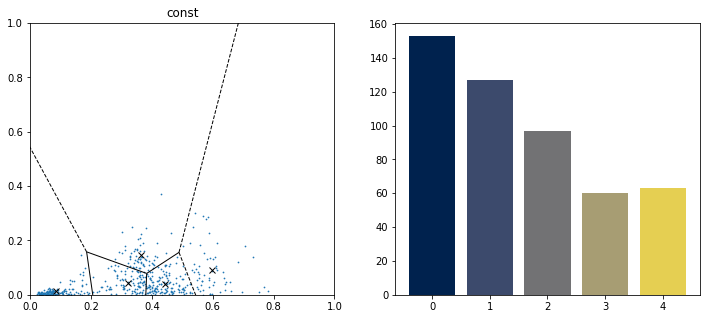

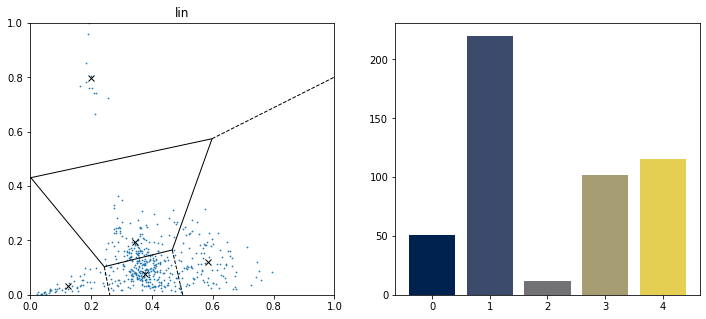

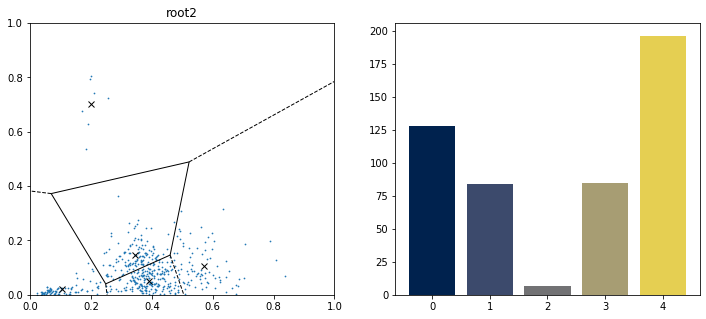

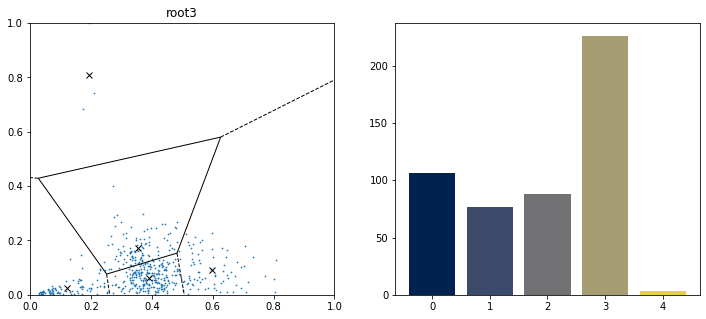

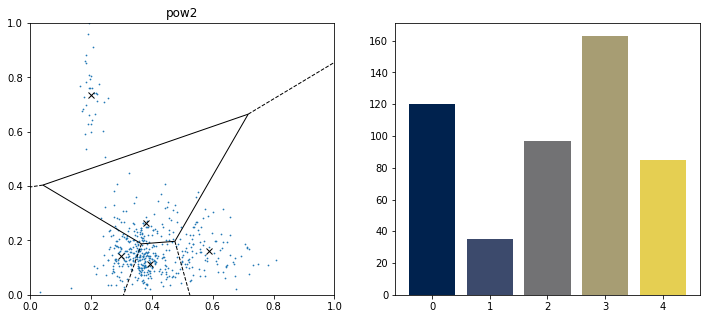

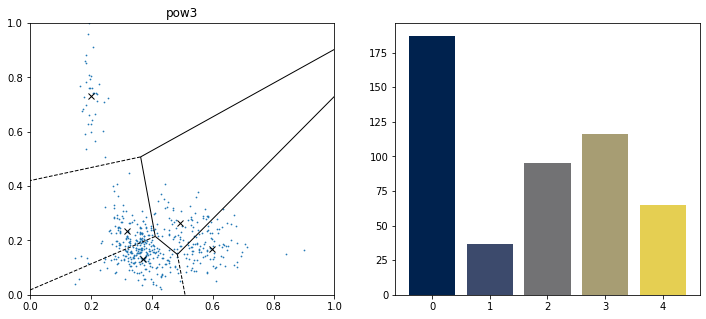

In [205]:
sampling_weights = {
    "const":None,
    "lin" : lambda x : x,
    "root2" : lambda x : x**(1/2),
    "root3" : lambda x : x**(1/2),
    "pow2" : lambda x : x**2,
    "pow3" : lambda x : x**3,
}

for name, weight in sampling_weights.items():
    plt.figure(figsize=(12,5))
    ax = plt.subplot(1,2,1)
    plt.title(name)
    bow = PersistentBow(5)
    transformed = [RandomPDSampler(500, weight).fit_transform(full_transformed, y)]
    bow.fit(transformed)
    plot_voronoi(bow, plot_range=(1, 1), ax = ax)
    plt.scatter(transformed[0][:, 0], transformed[0][:, 1], s=0.5)
    plt.subplot(1,2,2)
    plot_persistence_bow(transformed[0], bow)

### Wstepne proby uczenia

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from dionysus import wasserstein_distance
# w gudghim jest gudhi.representations.metrics.SlicedWassersteinDistance
# moze mozna go uzyc zeby nie doinstalowywac 2 biblioteki

ModuleNotFoundError: No module named 'dionysus'

In [21]:
# Generowanie wektorow persistence bag of words
# do dodania do pipelineu ? nie wiadomo jeszcze jak ?
# pewnie metoda transform mogla by to zwracac
def generate_vectors(diagrams, lr_bow):
    train_M = []
    for pd in diagrams:
        pred_clusters = lr_bow.predict([pd])[0]
        bins = list(range(lr_bow.n_clusters))
        histogram = np.bincount(pred_clusters, minlength=lr_bow.n_clusters)
        train_M.append(histogram)

    return np.array(train_M)

In [22]:
M_train = generate_vectors(X_train, bow)
M_test = generate_vectors(X_test, bow)

In [23]:
M_train.shape # ok mamy wektory a ich labelki to y_train

(280, 5)

In [24]:
svc = SVC(kernel='precomputed')

# Nie wiem czy te jadra tak to jest poprawnie
# Nie udalo mi sie wywnioskowac z artykulu jak ma funkcja k wygladac
kernel_train = np.dot(M_train, M_train.T)  # precomputed linear kernel

svc.fit(kernel_train, y_train)

kernel_test = np.dot(M_test, M_train.T)
y_pred = svc.predict(kernel_test)

accuracy_score(y_pred,y_test)

0.9857142857142858

In [36]:
def wasserstein_kernel(X, Y):
    out = np.zeros((X.shape[0], Y.shape[0]), dtype=np.float64)
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            out[i,j] = wasserstein_distance(x, y)
    return out

svc = SVC()
svc.fit(M_train, y_train)
y_pred = svc.predict(M_test)
print(accuracy_score(y_pred,y_test))

svc = SVC(kernel=wasserstein_kernel)
svc.fit(wasserstein_kernel(M_train,M_train), y_train)
y_pred= svc.predict(wasserstein_kernel(M_test, M_train))
print(accuracy_score(y_pred,y_test))

0.9857142857142858
0.0


In [35]:
wasserstein_kernel(M_train,M_train)

array([[5.31803968e+07, 4.88604042e+07, 1.62284990e+08, 6.97227940e+06,
        0.00000000e+00],
       [4.88604042e+07, 1.44551336e+07, 1.02188416e+08, 1.79493980e+06,
        0.00000000e+00],
       [1.62284990e+08, 1.02188416e+08, 3.09066263e+08, 1.45306224e+07,
        0.00000000e+00],
       [6.97227940e+06, 1.79493980e+06, 1.45306224e+07, 2.10505200e+05,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

In [190]:
class MyScaler():
    def __init__(self, copy=True):
        pass
    def fit(self,X,y=None):
        self.max = np.max(X)
    def transform(self,X):
        return X / self.max

In [199]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, MaxAbsScaler
diagrams=[np.array([[0.5,6.],[3.,10.],[5.,4.]]), np.array([[1.,20.],[2.,40.],[3.,60.]])]

In [200]:
for scaler in [MinMaxScaler, MyScaler, MaxAbsScaler]:
    scalers = [((0,), scaler(copy=False)), ((1,), scaler(copy=False))]
    ds = DiagramScaler(use=True, scalers=scalers)
    ds.fit(diagrams)
    out = ds.transform(diagrams)
    print(f'{scaler}\n',out[0],'\n\n', out[1],'\n')
    print('test:= ', ds.transform([np.array([[0., 2.]])]), '\n')

<class 'sklearn.preprocessing._data.MinMaxScaler'>
 [[0.         0.03571429]
 [0.55555556 0.10714286]
 [1.         0.        ]] 

 [[0.11111111 0.28571429]
 [0.33333333 0.64285714]
 [0.55555556 1.        ]] 

test:=  [array([[-0.11111111, -0.03571429]])] 

<class '__main__.MyScaler'>
 [[0.1        0.1       ]
 [0.6        0.16666667]
 [1.         0.06666667]] 

 [[0.2        0.33333333]
 [0.4        0.66666667]
 [0.6        1.        ]] 

test:=  [array([[0.        , 0.03333333]])] 

<class 'sklearn.preprocessing._data.MaxAbsScaler'>
 [[0.1        0.1       ]
 [0.6        0.16666667]
 [1.         0.06666667]] 

 [[0.2        0.33333333]
 [0.4        0.66666667]
 [0.6        1.        ]] 

test:=  [array([[0.        , 0.03333333]])] 



In [ ]:
# Tylko MinMaxScaler da nam ujemne wartości
# MaxAbs scaler zachowuje tak jak ten MyScaler wiec najlepiej bedzie mozna go dac
# Do zapytania ktore uzyc

In [ ]:
# Dziala ok mozna dodac do pipeline:
#TODO: dodac do pipeline [0,1] x [0,1] scaler
# DiagramScaler(
#         use=True,
#         scalers=[
#             ((0,), MinMaxScaler(copy=False)),
#             ((1,), MinMaxScaler(copy=False))
#         ]
#      )